In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

inout = []
for i in morph_db.index:
    for ii in range(len(morph_db.zgrism_hci[i])//2):
        if morph_db.zgrism_hci[i][2*ii] <= morph_db.zgrism[i] <= morph_db.zgrism_hci[i][2*ii+1]:
            if(morph_db.zgrism_hci[i][2*ii+1] - morph_db.zgrism_hci[i][2*ii]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
morph_db['inout'] = inout
morph_db = morph_db.query('inout == "i" and n_f < 3 and Re < 20')

mdb = morph_db.query('n_f < 3 and lmass >= 10.5')
mdbs = morph_db.query('n_f < 3 and lmass >= 11 and Re < 2')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


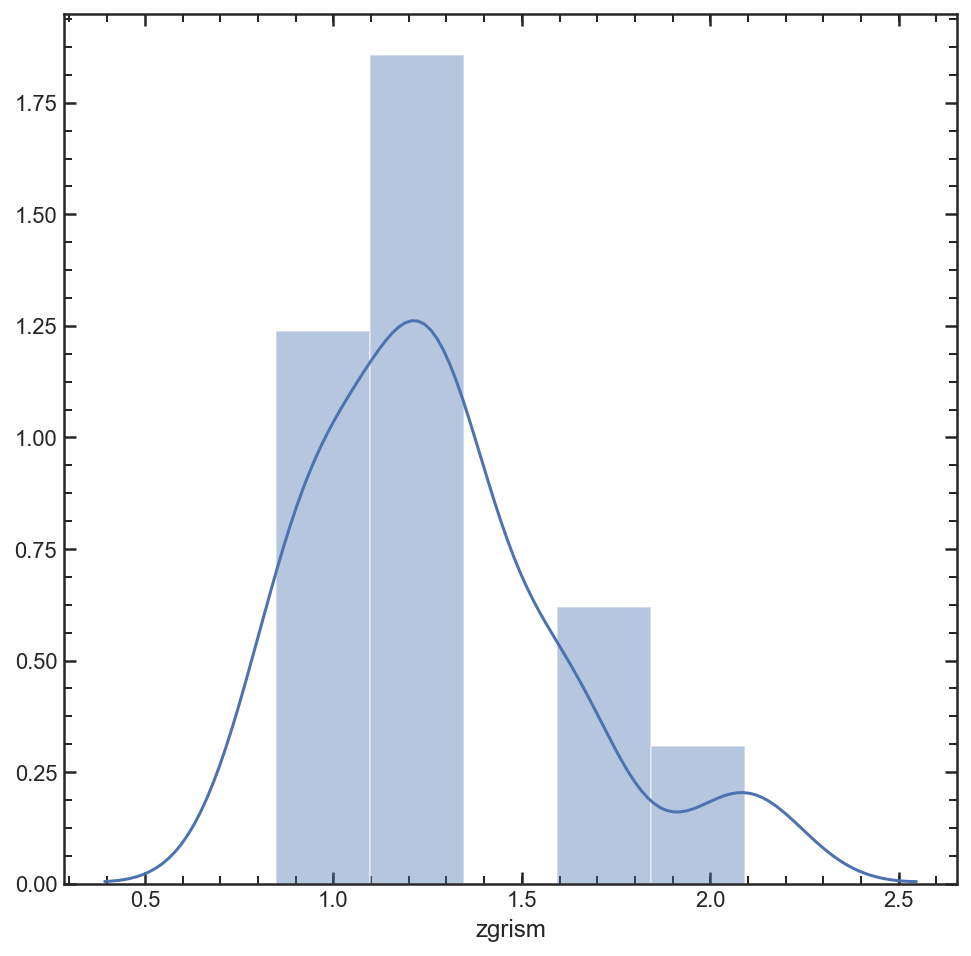

In [3]:
plt.figure(figsize=[8,8])
sea.distplot(mdbs.zgrism)

In [4]:
sb_z, sb_sfh = np.loadtxt('../data/evo_path/SB_SFH.dat').T
ef_z, ef_sfh = np.loadtxt('../data/evo_path/EF_SFH.dat').T

In [5]:
def get_agebins(maxage, binnum = 10):
    lages = [0,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9][: binnum + 1]
    
    nbins = len(lages) - 1

    tbinmax = (maxage * 0.85) * 1e9
    lim1, lim2 = 7.4772, 8.0
    agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(maxage*1e9)]
    return np.array([agelims[:-1], agelims[1:]]).T

In [6]:
# 2.566
agebins = get_agebins(2.566+1.85)

In [7]:
sb_lwa = cosmo.lookback_time(sb_z).value - min(cosmo.lookback_time(sb_z)).value
ef_lwa = cosmo.lookback_time(ef_z).value - min(cosmo.lookback_time(ef_z)).value
blims = 10**agebins.T[1] * 1E-9
blims = np.append(0.0, blims)

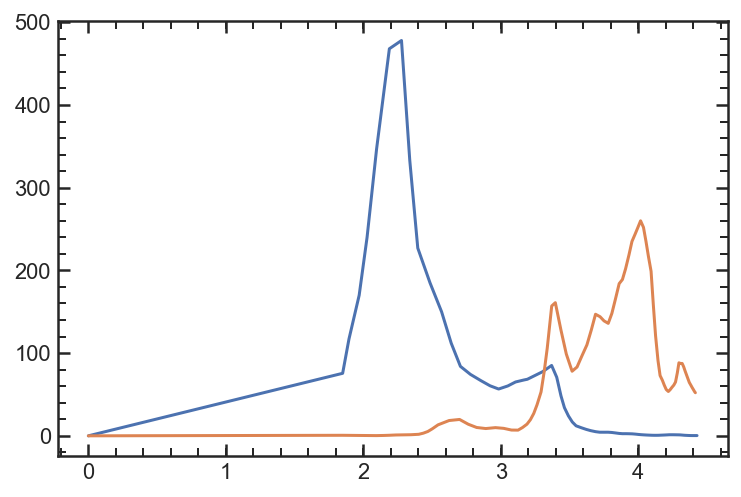

In [8]:
plt.plot((np.append(-1.85,sb_lwa) + 1.85), np.append(0,sb_sfh))
plt.plot((np.append(-1.85,ef_lwa) + 1.85), np.append(0,ef_sfh))

In [34]:
isb_lwa = np.linspace((np.append(-1.85,sb_lwa) + 1.85)[0],(np.append(-1.85,sb_lwa) + 1.85)[-1],1000)
isb_sfh = interp1d((np.append([-1.85, -0.15],sb_lwa) + 1.85),np.append([0,1.75],sb_sfh))(isb_lwa)

ief_lwa = np.linspace((np.append(-1.85,ef_lwa) + 1.85)[0],(np.append(-1.85,ef_lwa) + 1.85)[-1],1000)
ief_sfh = interp1d((np.append(-1.85,ef_lwa) + 1.85),np.append(0,ef_sfh))(ief_lwa)

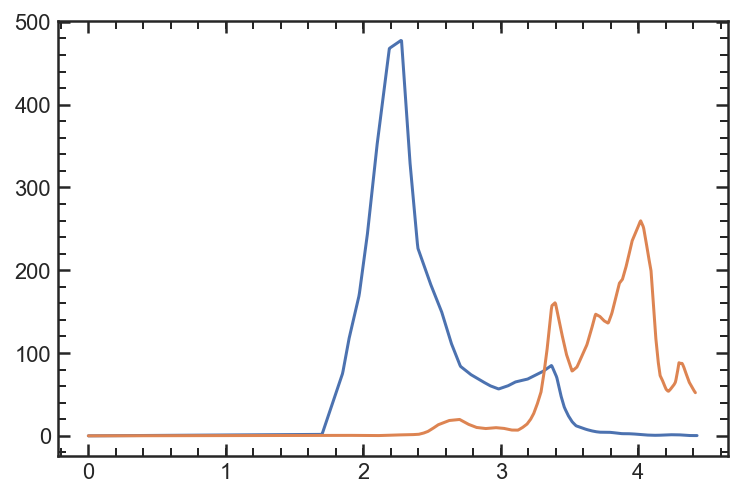

In [35]:
plt.plot(isb_lwa, isb_sfh)
plt.plot(ief_lwa, ief_sfh)

0.00014066774715095487
0.0015860087073127356
0.003180855051811586
0.00898742220394841
0.025391235481306434
0.07170048385807383
0.2024054821431116
0.4862176457444667
65.22323378068721
94.68016882817801


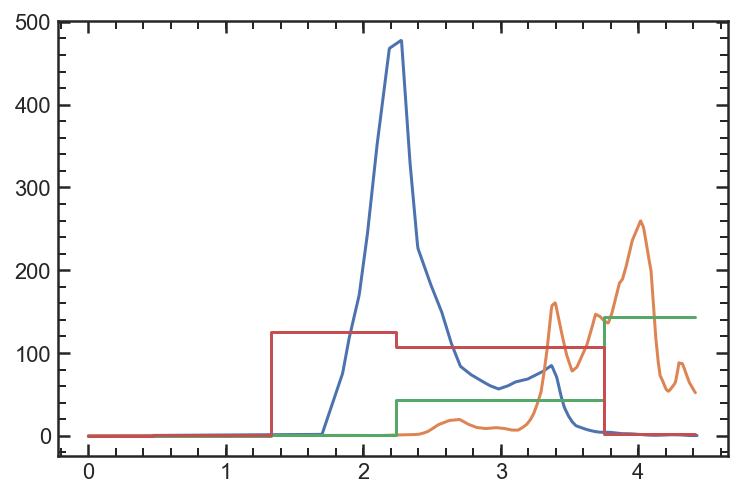

In [36]:
plt.plot(isb_lwa, isb_sfh)
plt.plot(ief_lwa, ief_sfh)

ef_T = [0]
ef_SFH= []
for i in range(len(blims) - 1):
    sfh_bin = []
    for ii in range(len(ief_lwa)):
        if blims[i] <= ief_lwa[ii] < blims[i+1]:
            sfh_bin.append(ief_sfh[ii])
    ef_SFH.append(np.mean(sfh_bin))
    ef_SFH.append(np.mean(sfh_bin))
    if i < len(blims) - 2 : 
        ef_T.append(blims[i+1])
        ef_T.append(blims[i+1])
    else:
        ef_T.append(blims[i+1])
    print(np.mean(sfh_bin) * (blims[i+1] - blims[i]))

plt.plot(ef_T,ef_SFH)

sb_T = [0]
sb_SFH= []
for i in range(len(blims) - 1):
    sfh_bin = []
    for ii in range(len(isb_lwa)):
        if blims[i] <= isb_lwa[ii] < blims[i+1]:
            sfh_bin.append(isb_sfh[ii])
    sb_SFH.append(np.mean(sfh_bin))
    sb_SFH.append(np.mean(sfh_bin))
    if i < len(blims) - 2 : 
        sb_T.append(blims[i+1])
        sb_T.append(blims[i+1])
    else:
        sb_T.append(blims[i+1])

#     print(np.mean(sfh_bin) * (blims[i+1] - blims[i]))
        
plt.plot(sb_T,sb_SFH)

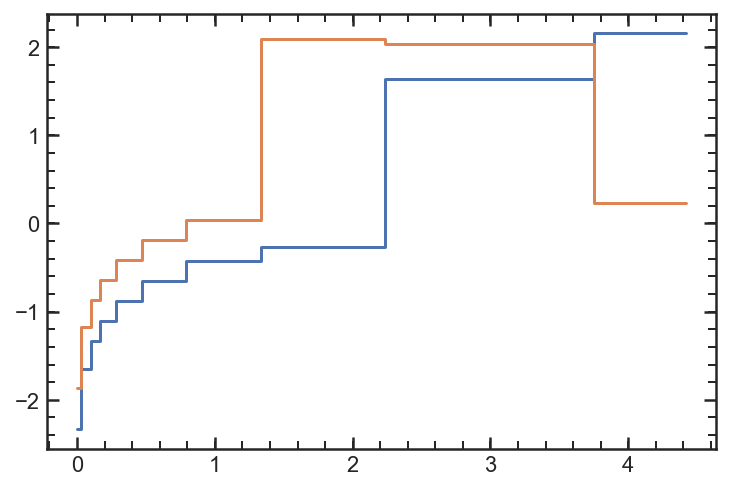

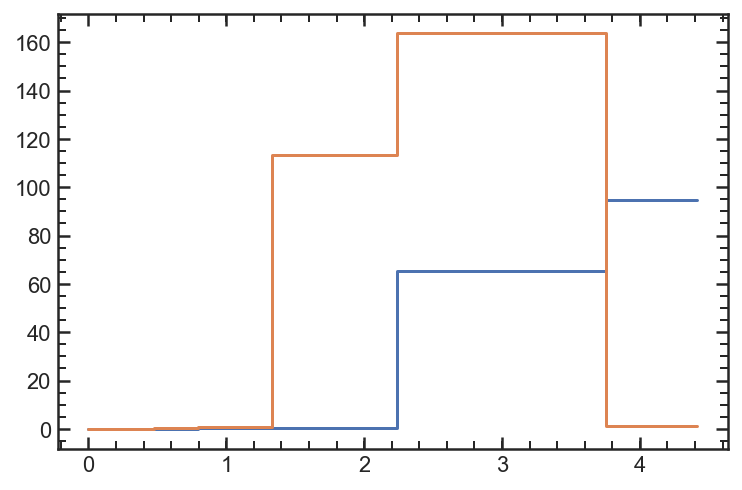

In [66]:
plt.figure()
plt.plot(ef_T,np.log10(ef_SFH))
plt.plot(sb_T,np.log10(sb_SFH))

plt.figure()
plt.plot(ef_T,np.array(ef_mbins))
plt.plot(sb_T,np.array(sb_mbins))

In [54]:
ef_mbins = []
for i in range(len(ef_T)//2):
    mass = ef_SFH[i*2+1] * (ef_T[i*2+1] - ef_T[i*2])
    
    if i < len(ef_T)//2 : 
        ef_mbins.append(mass)
        ef_mbins.append(mass)
    else:
        ef_mbins.append(mass)
        
sb_mbins = []
for i in range(len(sb_T)//2):
    mass = sb_SFH[i*2+1] * (sb_T[i*2+1] - sb_T[i*2])
    
    if i < len(sb_T)//2 : 
        sb_mbins.append(mass)
        sb_mbins.append(mass)
    else:
        sb_mbins.append(mass)

In [64]:
sb_mbins

[0.00041075079726690623,
 0.00041075079726690623,
 0.004631156424946977,
 0.004631156424946977,
 0.009288118811769896,
 0.009288118811769896,
 0.02624333516683499,
 0.02624333516683499,
 0.07414258370361324,
 0.07414258370361324,
 0.20936591013661407,
 0.20936591013661407,
 0.589796668559963,
 0.589796668559963,
 113.23383033003728,
 113.23383033003728,
 163.59516042477648,
 163.59516042477648,
 1.1419208688719658,
 1.1419208688719658]

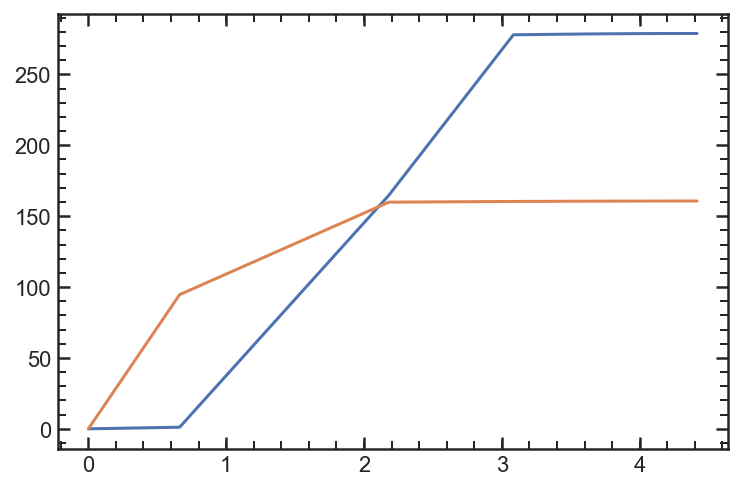

In [42]:
T=[0]
M=[0]

lbt = np.abs(sb_T - sb_T[-1])[::-1]
lbsfr = sb_SFH[::-1]

for i in range(len(lbt)//2):
    mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
    M.append(M[i] + mass)
    T.append(lbt[i*2+1])
    
plt.plot(T,M)

T=[0]
M=[0]

lbt = np.abs(ef_T - ef_T[-1])[::-1]
lbsfr = ef_SFH[::-1]

for i in range(len(lbt)//2):
    mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
    M.append(M[i] + mass)
    T.append(lbt[i*2+1])
    
plt.plot(T,M)

0.1531588806680444 13774 2.652500656016183
0.3542262367928742 17070 4.176152106766585
0.0446623091545133 22213 5.657209759485417
0.16027460826632445 27185 2.9868710817276236
0.09111547366989958 37340 3.751786693206122
0.0008390481516691306 37686 3.2510609102134893
-0.01939289757104301 39804 3.002544670007443
0.09072954666040922 40597 2.3589630486019972
0.029819226740751548 41520 4.382773386805168
0.02434560701135191 17746 5.640696320380857
0.030273765008758557 21738 5.743797573958715
0.34195059016321405 39012 7.063552848581166
-0.14373592785585165 46066 6.209742281626355


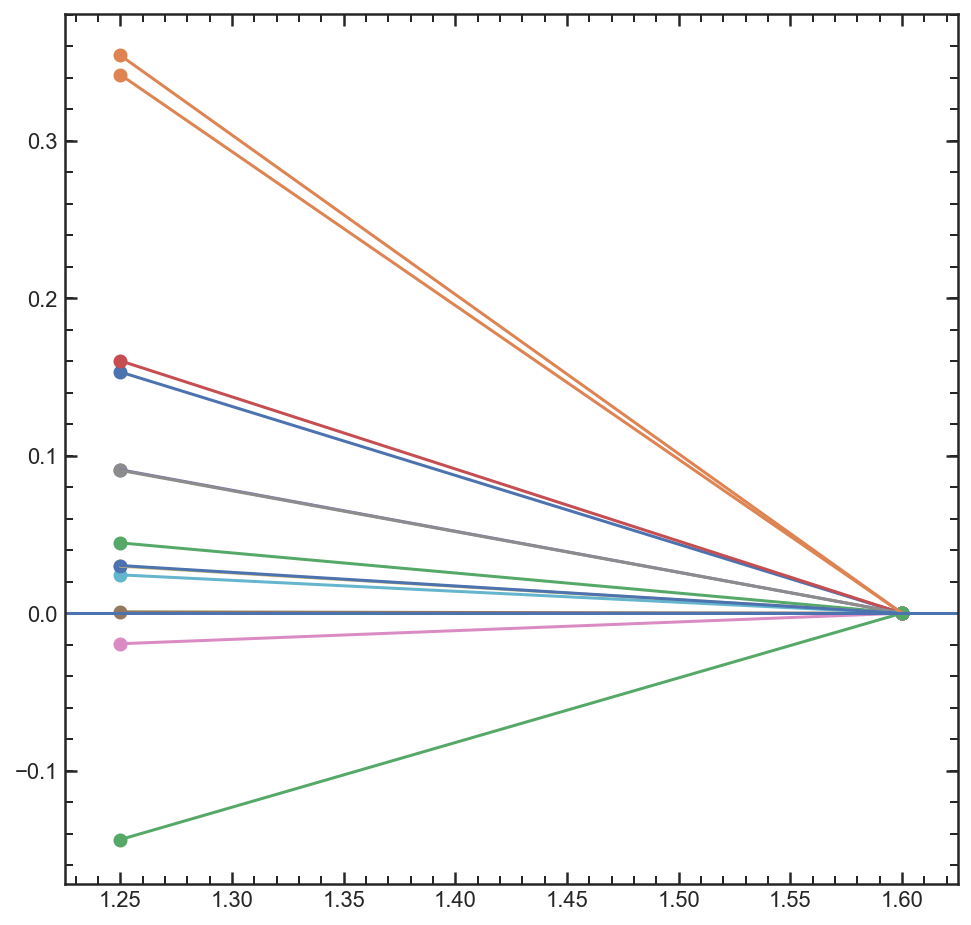

In [133]:
idx = 0
plt.figure(figsize=[8,8])
for i in mdbs.index:
    plt.scatter([1.25,1.6],[mdbs.Re_f125[i] - mdbs.Re_f160[i], mdbs.Re_f160[i] - mdbs.Re_f160[i]])
    plt.plot([1.25,1.6],[mdbs.Re_f125[i]-mdbs.Re_f160[i],mdbs.Re_f160[i]-mdbs.Re_f160[i]])
    print(mdbs.Re_f125[i]-mdbs.Re_f160[i], mdbs.id[i], mdbs.z_50[i])
plt.axhline(0)

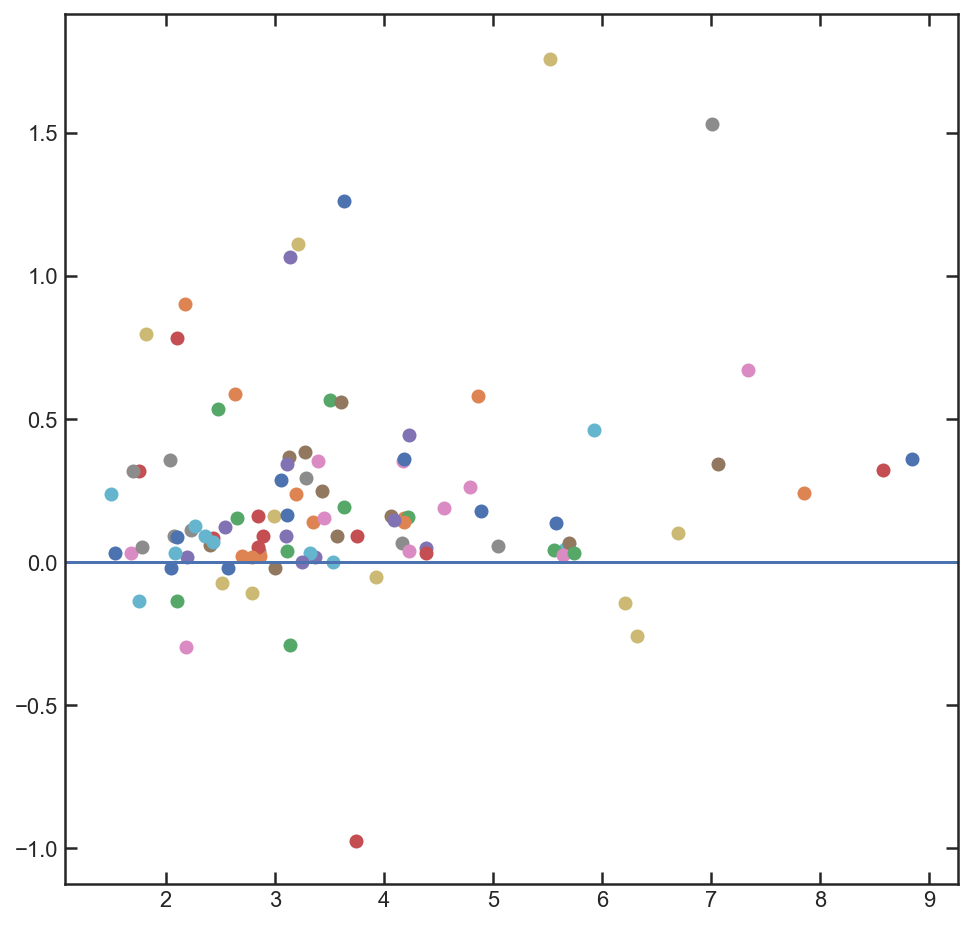

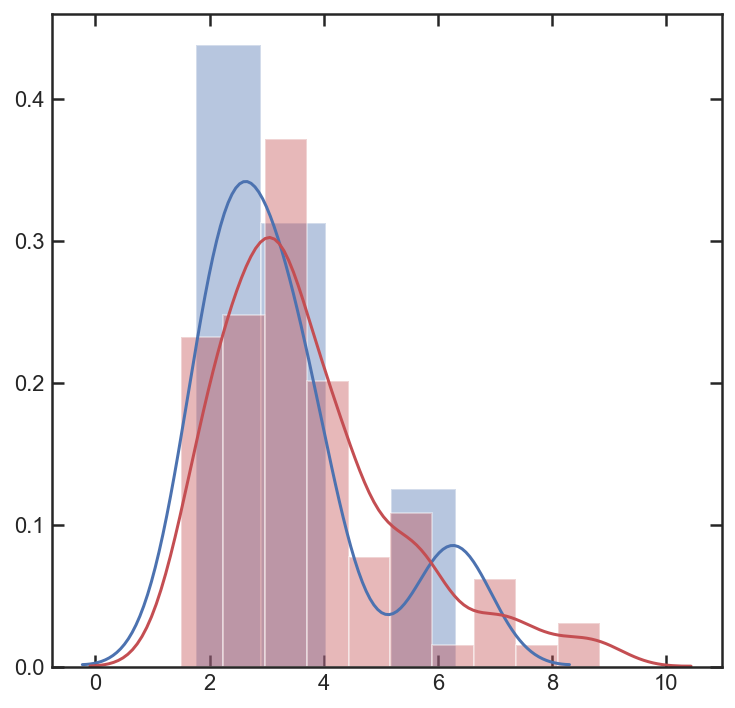

In [102]:
idx = 0
plt.figure(figsize=[8,8])

EF = []
SB = []
for i in mdb.index:
    plt.scatter(mdb.z_50[i],mdb.Re_f125[i]-mdb.Re_f160[i])
    
    if mdb.Re_f125[i]-mdb.Re_f160[i] < 0:
        SB.append(mdb.z_50[i])
    else:
        EF.append(mdb.z_50[i])
        
plt.axhline(0)

plt.figure(figsize=[6,6])
sea.distplot(SB, color = 'b')
sea.distplot(EF, color = 'r')


(10.03, 8.85)

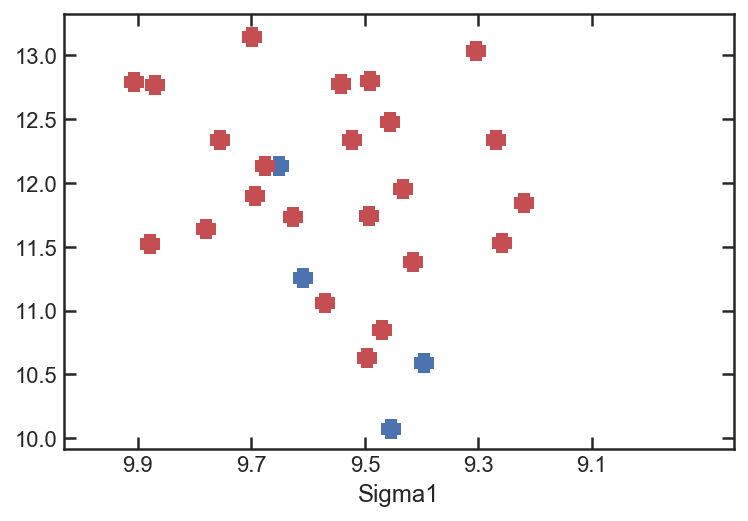

In [113]:
sb_mdb = mdb.query('Re_f125 - Re_f160 <= 0 and 0.9 < zgrism < 1.1 and n_f < 2')
ef_mdb = mdb.query('Re_f125 - Re_f160 > 0 and 0.9 < zgrism < 1.1 and n_f < 2')

sea.scatterplot(np.log10(sb_mdb.Sigma1), cosmo.lookback_time(sb_mdb.z_50),
        marker="+", color = 'b', alpha = 1, linewidth = 10)
sea.scatterplot(np.log10(ef_mdb.Sigma1), cosmo.lookback_time(ef_mdb.z_50),
        marker="+", color = 'r', alpha = 1, linewidth = 10)

plt.xticks([ 9.9, 9.7, 9.5, 9.3, 9.1])
plt.xlim(10.03,8.85)

In [85]:
sfh_17 = Rescale_sfh('GND', 17070)
sfh_46 = Rescale_sfh('GSD', 46066)
sfh_21 = Rescale_sfh('GND', 21738)
sfh_40 = Rescale_sfh('GSD', 40597)

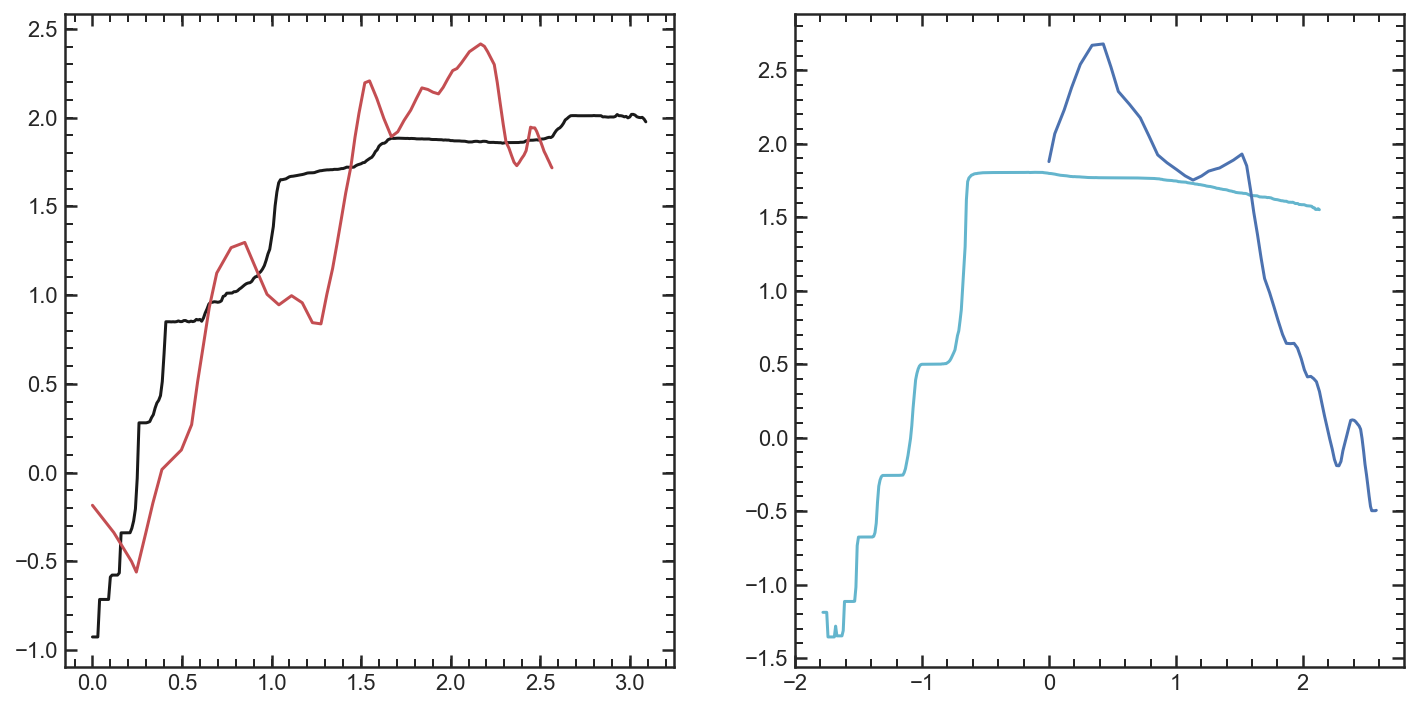

In [95]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize=[12,6])
plt.subplot(gs[0])
plt.plot(sfh_21.LBT, np.log10(sfh_21.SFH), 'k')
plt.plot(ef_lwa, np.log10(ef_sfh), 'r')

plt.subplot(gs[1])
plt.plot(sfh_40.LBT - 1.78, np.log10(sfh_40.SFH), 'c')
plt.plot(sb_lwa, np.log10(sb_sfh), 'b')


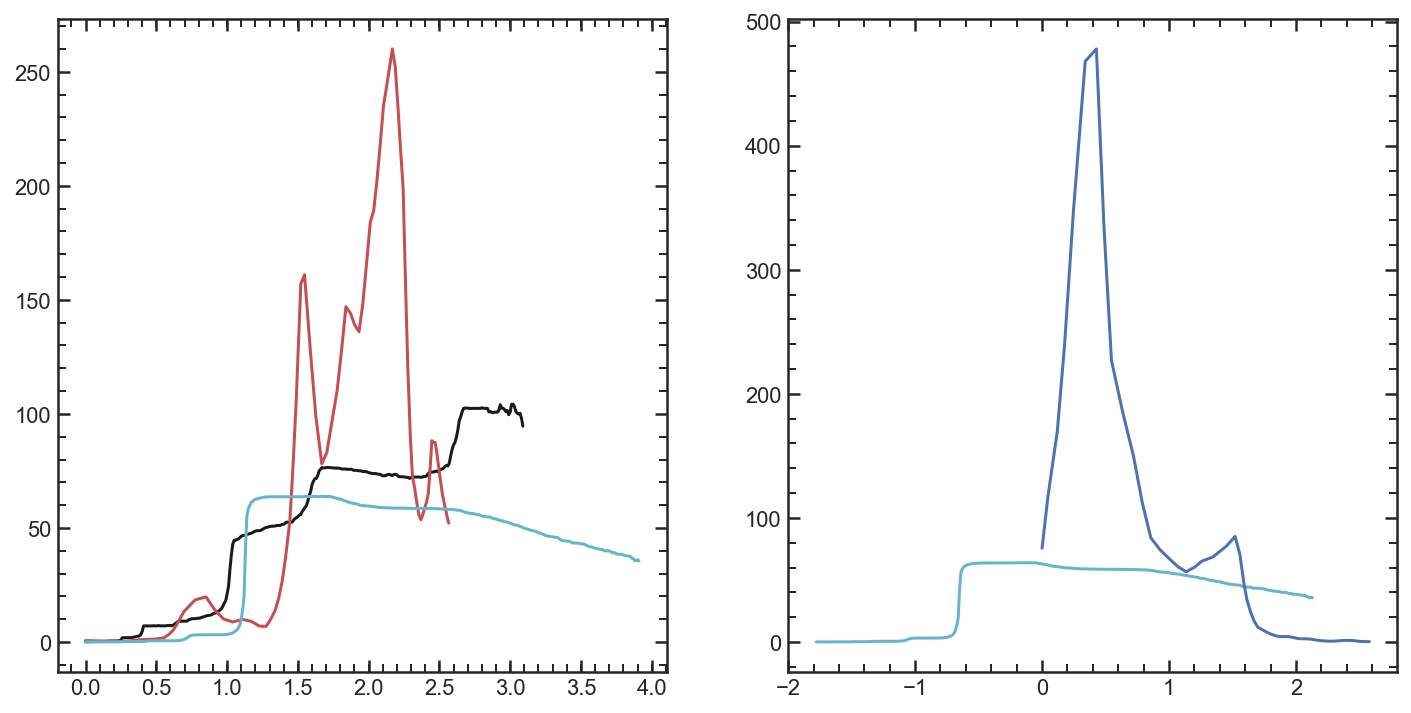

In [96]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize=[12,6])
plt.subplot(gs[0])
plt.plot(sfh_21.LBT, sfh_21.SFH, 'k')
plt.plot(ef_lwa, ef_sfh, 'r')
plt.plot(sfh_40.LBT, sfh_40.SFH, 'c')

plt.subplot(gs[1])
plt.plot(sfh_40.LBT - 1.78, sfh_40.SFH, 'c')
plt.plot(sb_lwa, sb_sfh, 'b')


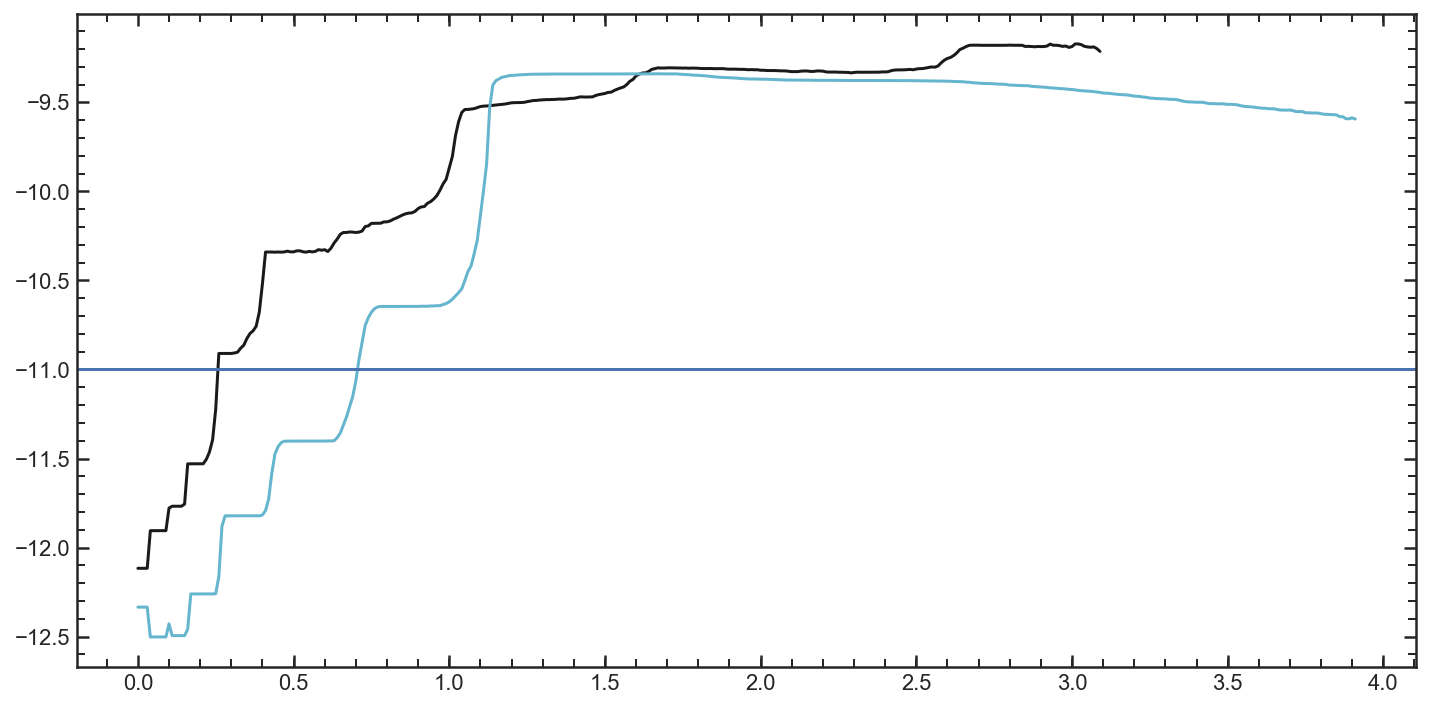

In [106]:
plt.figure(figsize=[12,6])
plt.plot(sfh_21.LBT, np.log10(sfh_21.SFH/10**11.19), 'k')
plt.plot(sfh_40.LBT , np.log10(sfh_40.SFH/10**11.145), 'c')
plt.axhline(-11)

In [104]:
mdbs[['id','lmass']]

,id,lmass
3,13774,11.01559
8,17070,11.15457
12,22213,11.18690
22,27185,11.10648
40,37340,11.01045
41,37686,11.10863
53,39804,11.08821
57,40597,11.14540
61,41520,11.07890
87,17746,11.05834


In [86]:
cosmo.lookback_time(2).value - cosmo.lookback_time(1.22).value

1.7825829535921685

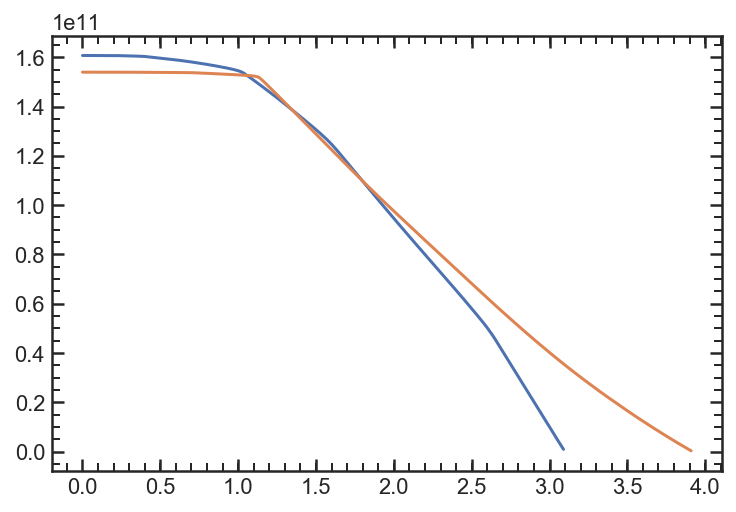

In [114]:
plt.plot(sfh_21.LBT[::-1],np.cumsum(sfh_21.SFH[::-1]) * (sfh_21.LBT[1] - sfh_21.LBT[0])*1E9)
plt.plot(sfh_40.LBT[::-1],np.cumsum(sfh_40.SFH[::-1]) * (sfh_40.LBT[1] - sfh_40.LBT[0])*1E9)

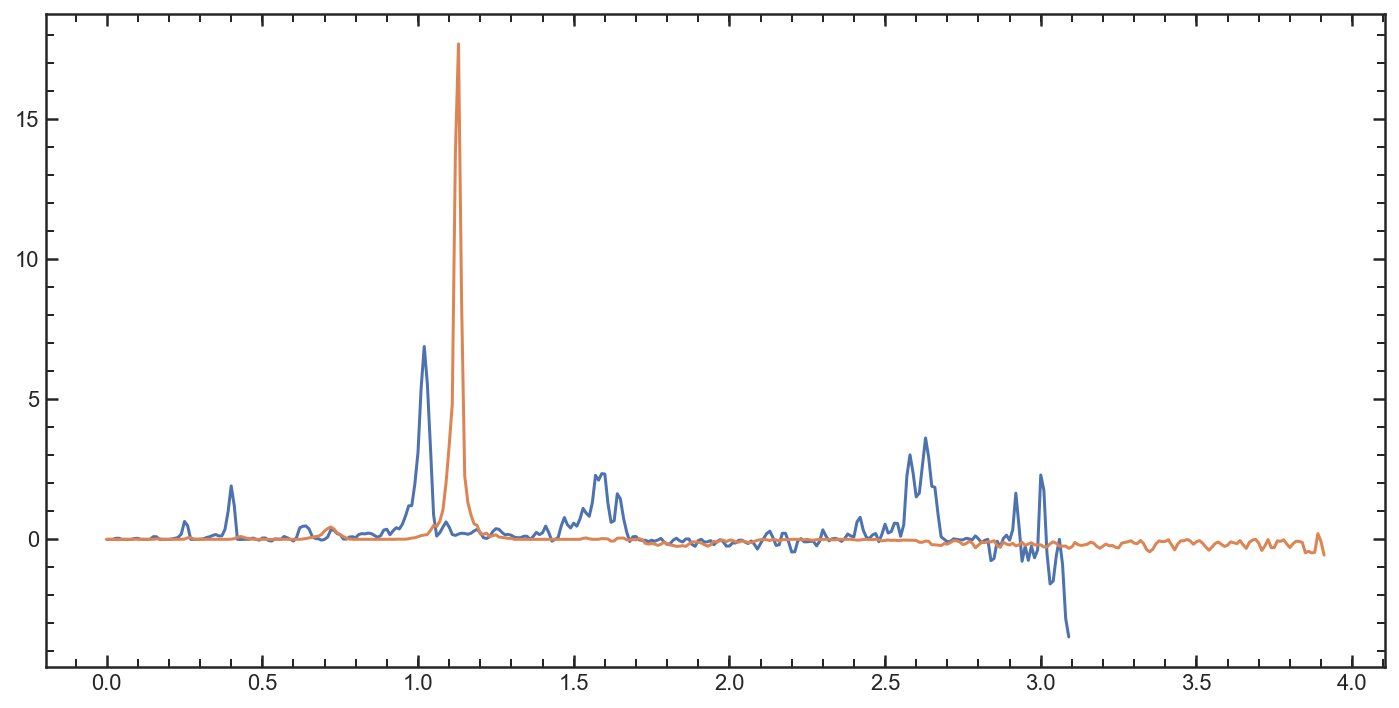

In [126]:
plt.figure(figsize=[12,6])
plt.plot(sfh_21.LBT, np.gradient(sfh_21.SFH))
plt.plot(sfh_40.LBT, np.gradient(sfh_40.SFH))

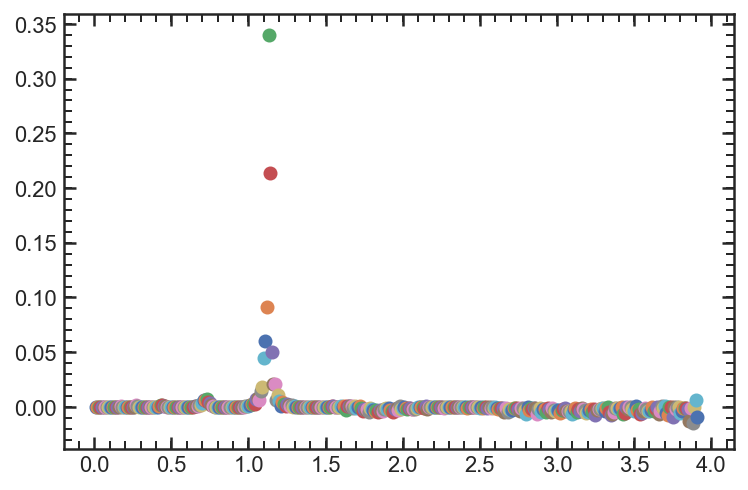

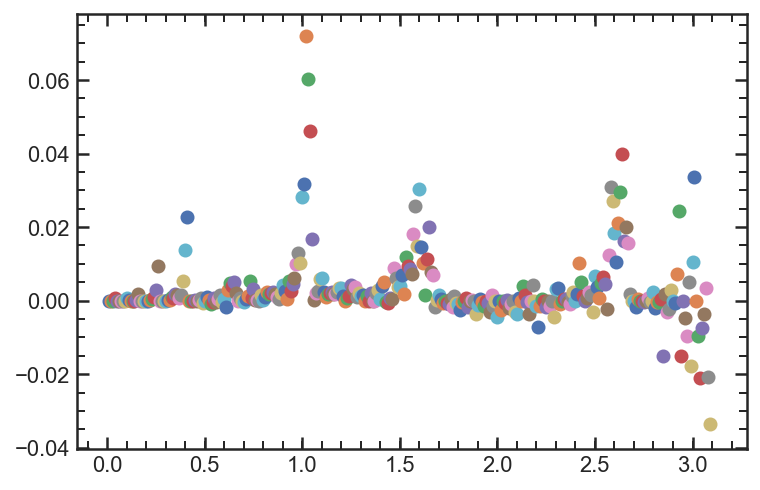

In [130]:
plt.figure()

for i in range(len(sfh_40.LBT)-1):
    diff = (sfh_40.SFH[i+1] - sfh_40.SFH[i]) / max(sfh_40.SFH)
    plt.scatter(sfh_40.LBT[i+1], diff)
    
plt.figure()
for i in range(len(sfh_21.LBT)-1):
    diff = (sfh_21.SFH[i+1] - sfh_21.SFH[i]) / max(sfh_21.SFH)
    plt.scatter(sfh_21.LBT[i+1], diff)

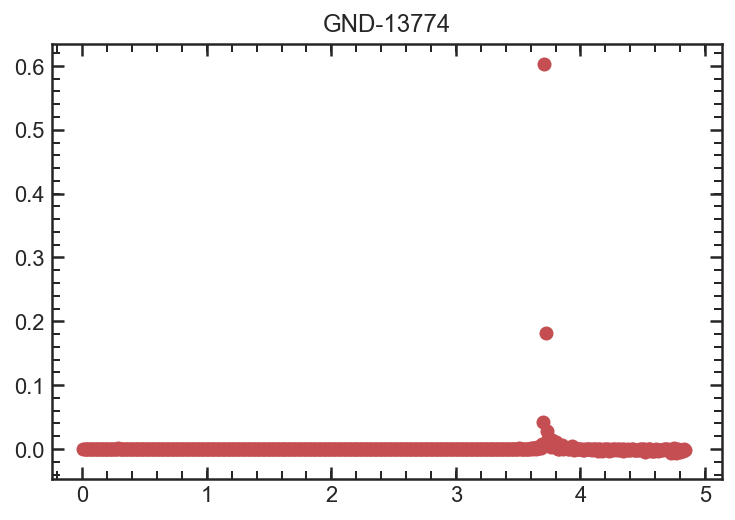

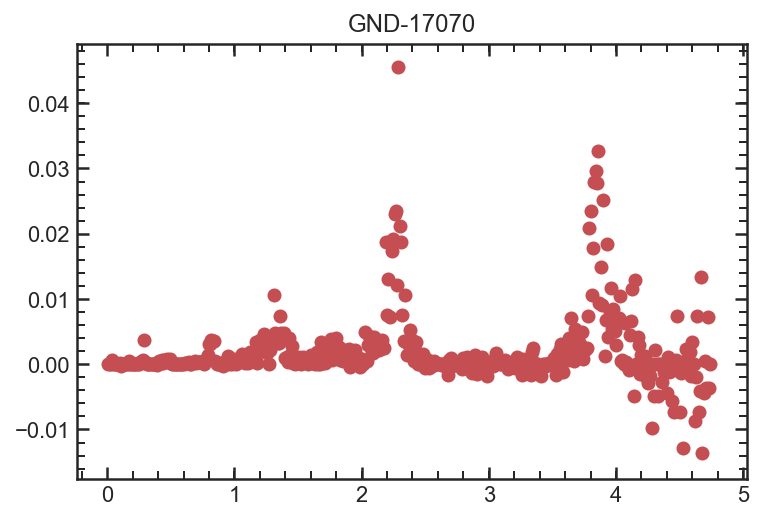

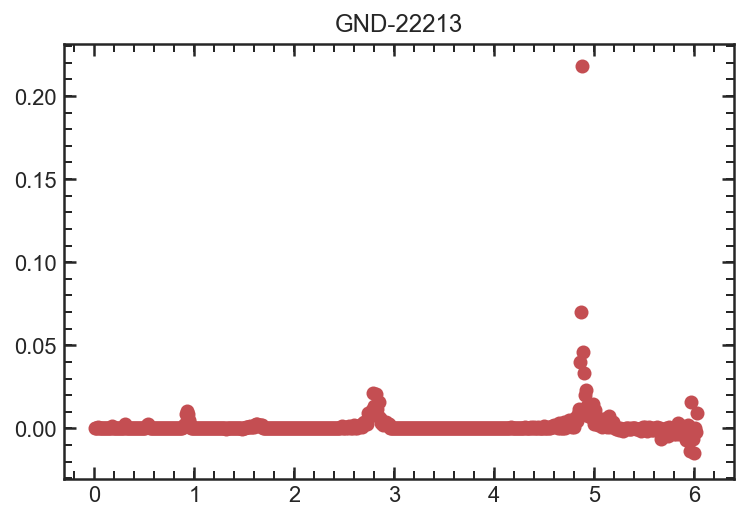

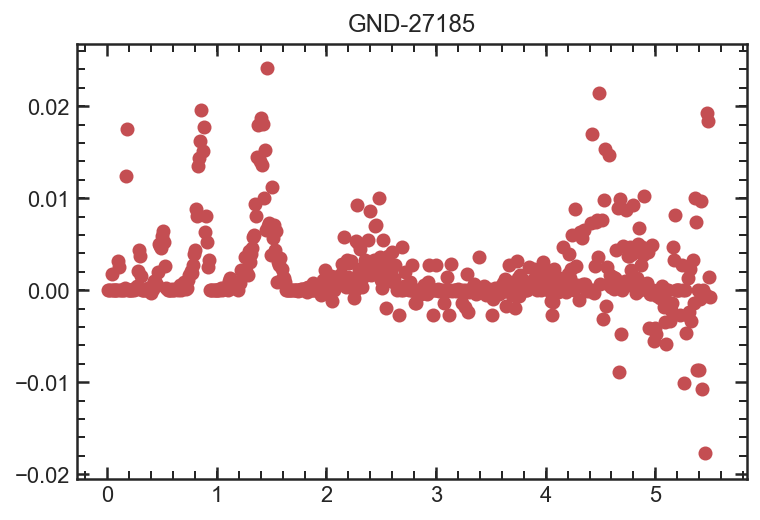

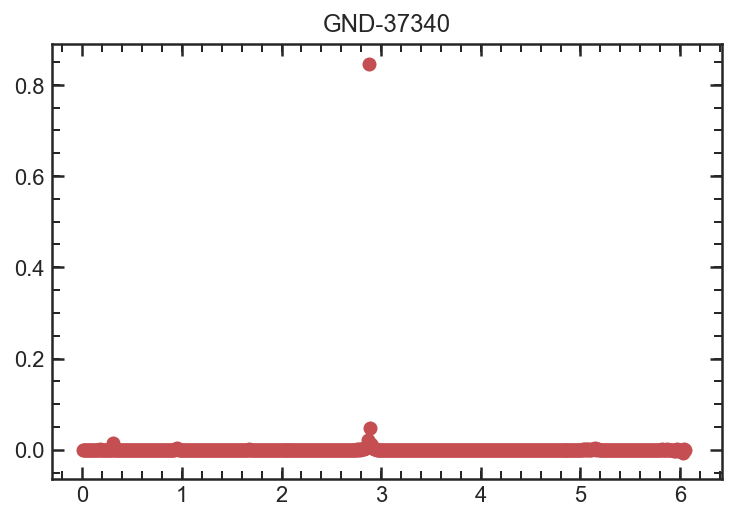

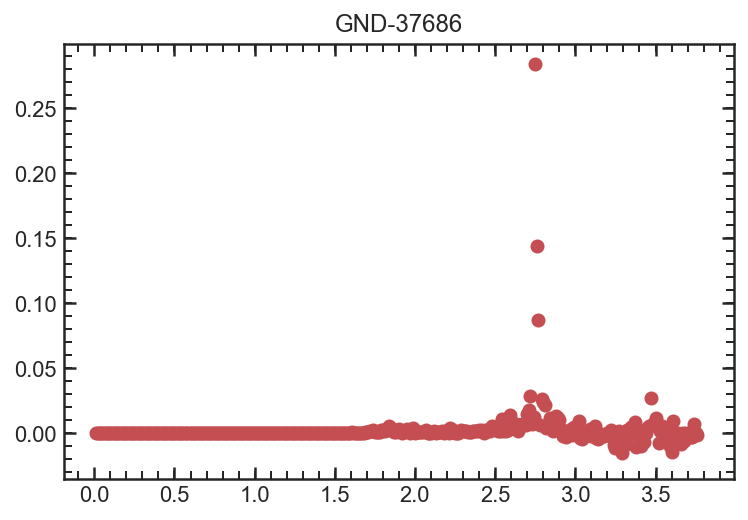

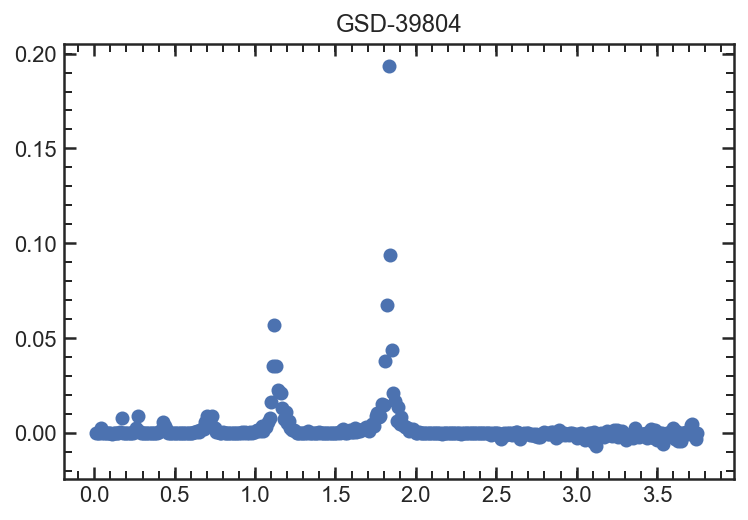

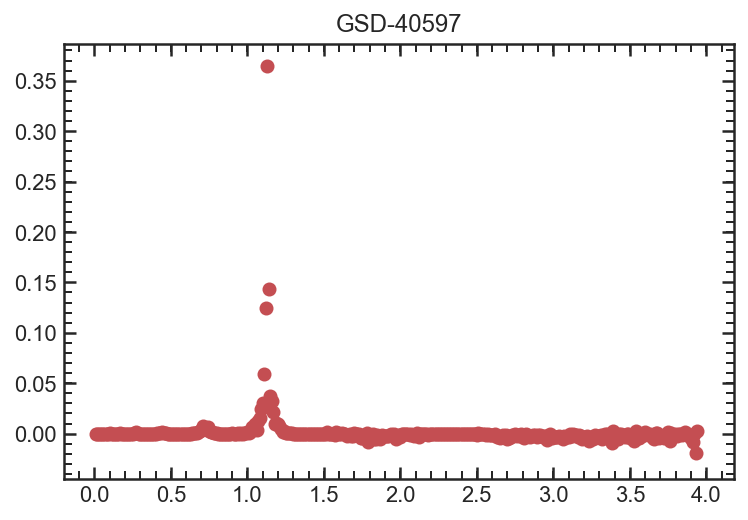

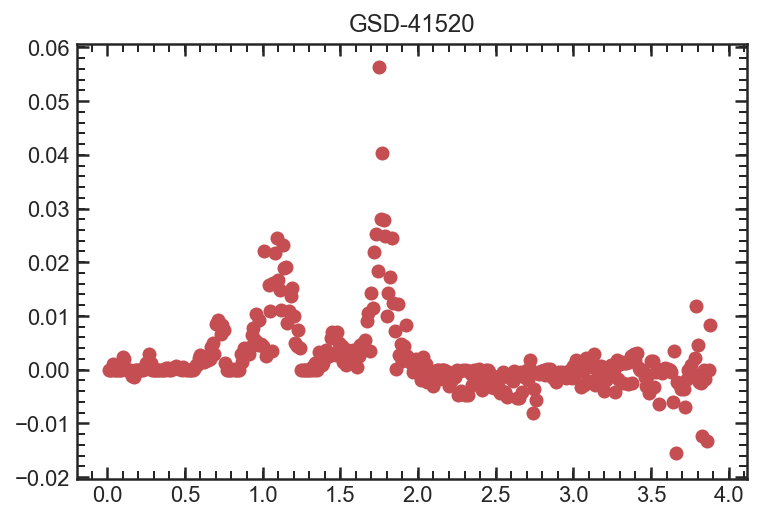

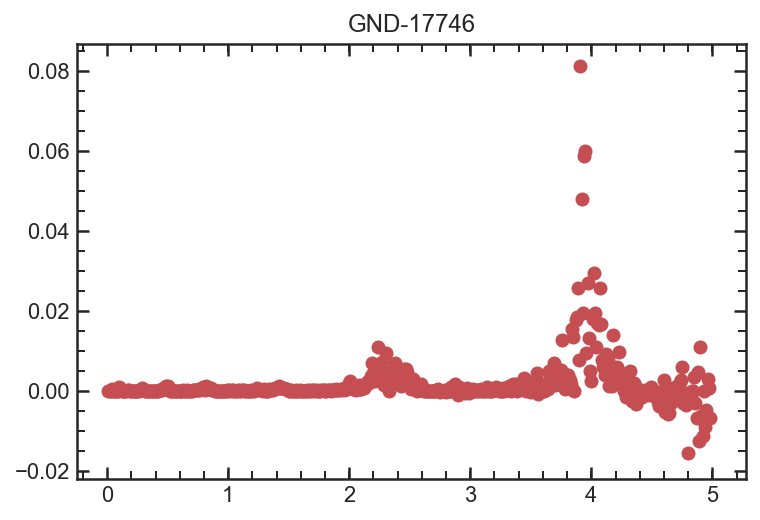

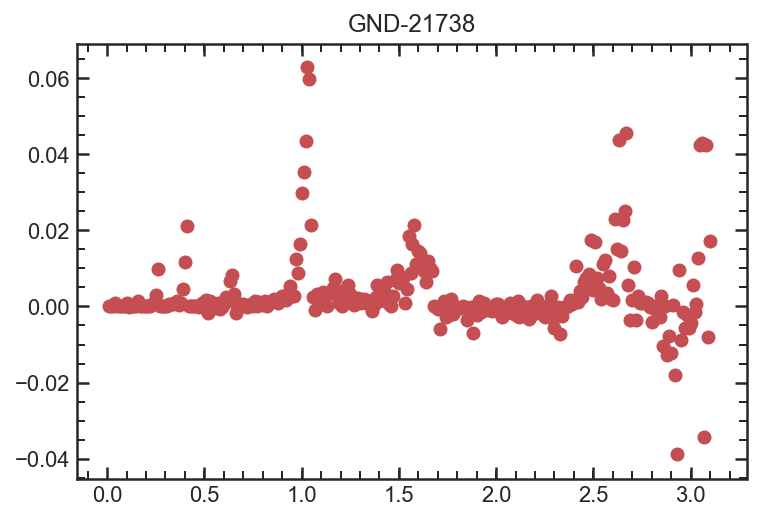

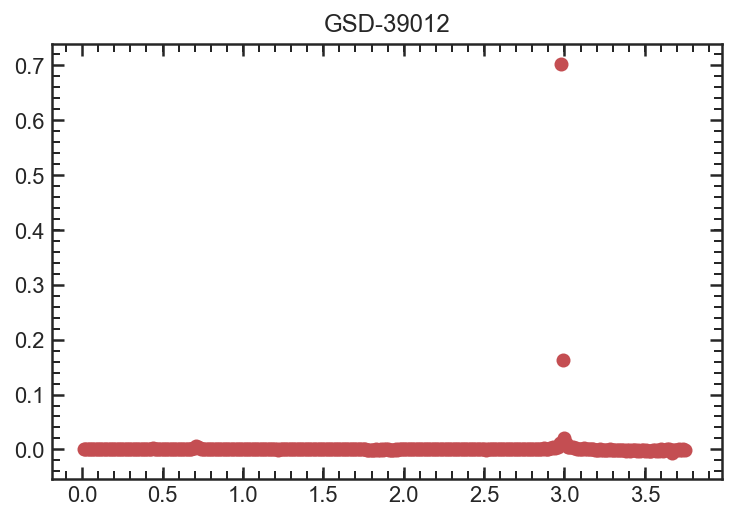

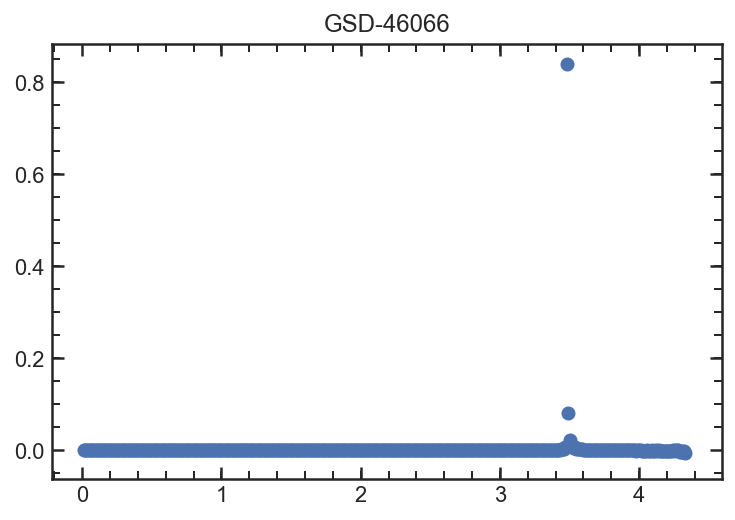

In [138]:
for i in mdbs.index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdbs.field[i], mdbs.id[i]))
    plt.figure()
    plt.title('{0}-{1}'.format(mdbs.field[i], mdbs.id[i]))
    
    if mdbs.Re_f125[i] - mdbs.Re_f160[i] < 0:
        C = 'b'
    
    else:
        C = 'r'
    
    for ii in range(len(lbt)-1):
        diff = (sfh[ii+1] - sfh[ii]) / max(sfh)
        plt.scatter(lbt[ii+1], diff, color = C)

In [121]:
mdbhz = morph_db.query('n_f < 3 and zgrism >= 2 and lmass > 10')

0.030273765008758557 21738 5.743797573958715
0.5594939864113195 22774 3.606953148780409
0.670269279036892 23018 7.334533021041155
0.46085396514918076 28890 5.9233115546437745
0.44354550519345626 32933 4.231039629730547
0.5802009770830567 48464 4.862172459369712


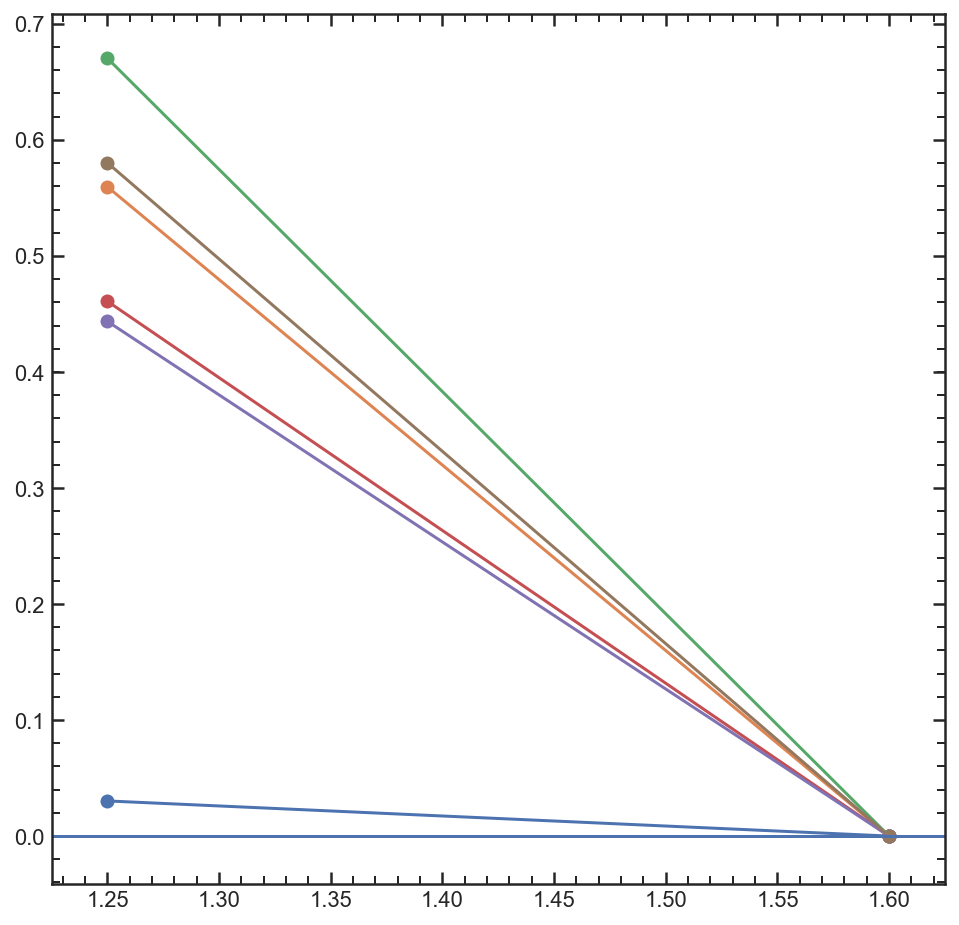

In [122]:
idx = 0
plt.figure(figsize=[8,8])
for i in mdbhz.index:
    plt.scatter([1.25,1.6],[mdbhz.Re_f125[i] - mdbhz.Re_f160[i], mdbhz.Re_f160[i] - mdbhz.Re_f160[i]])
    plt.plot([1.25,1.6],[mdbhz.Re_f125[i]-mdbhz.Re_f160[i],mdbhz.Re_f160[i]-mdbhz.Re_f160[i]])
    print(mdbhz.Re_f125[i]-mdbhz.Re_f160[i], mdbhz.id[i], mdbhz.z_50[i])
plt.axhline(0)

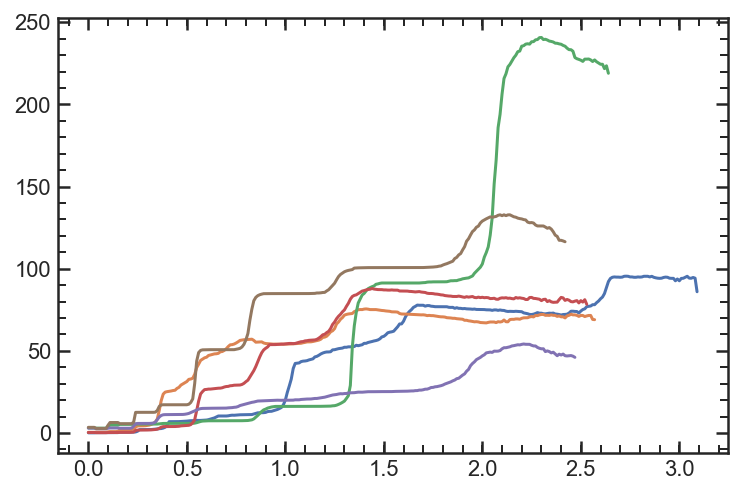

In [123]:

for i in mdbhz.index:
    sfh = Rescale_sfh(mdbhz.field[i], mdbhz.id[i])
    plt.plot(sfh.LBT, sfh.SFH)

In [131]:
for i in mdb.index:
    sfh = Rescale_sfh(mdb.field[i], mdb.id[i])
    np.save('../data/SFH/{0}_{1}'.format(mdb.field[i], mdb.id[i]),[sfh.LBT, sfh.SFH])

(10.03, 8.85)

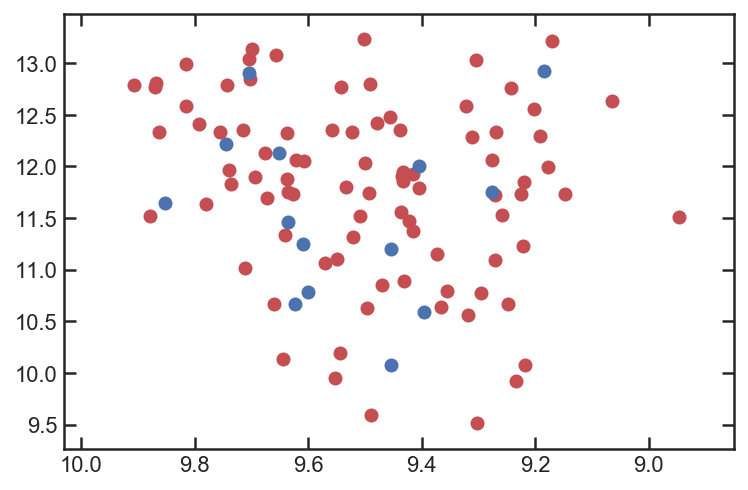

In [15]:
for i in mdb.index:
    if mdb.Re_f125[i] - mdb.Re_f160[i] < 0:
        C = 'b'
    
    else:
        C = 'r'
    
    plt.scatter(np.log10(mdb.Sigma1[i]), cosmo.lookback_time(mdb.z_50[i]), color = C)
    
# plt.yticks([2,3,4,5,6,7,9], cosmo.lookback_time([2,3,4,5,6,7,9]).value)
plt.xlim(10.03,8.85)

In [98]:
from spec_tools import Derive_SFH_weights
def Gen_PPF(x,px):
    return interp1d(np.cumsum(px) / np.cumsum(px).max(),x)

class Rescale_sfh(object):
    def __init__(self, field, galaxy, trials = 1000):

        ppf_dict = {}
        params = ['a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'lm']

        for i in params:
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(field, galaxy, i))
            ppf_dict[i] = Gen_PPF(x,px)

        idx = 0
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
        rshift = x[px == max(px)][0]
        self.fulltimes = np.arange(0.0,Oldest_galaxy(rshift),0.01)
        sfr_grid = []
        ssfr_grid = []
        t_50_grid = []
        t_80_grid = []
        t_90_grid = []
        t_q_grid = []

        while idx < trials:
            try:
                draw = np.zeros(len(params))

                for i in range(len(draw)):
                    draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

                time, sfr, tmax = convert_sfh(get_agebins(draw[0]), draw[1:11], maxage = draw[0]*1E9)

                T=[0]
                M=[0]
                for i in range(len(time)//2):
                    mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
                    M.append(M[i] + mass)
                    T.append(time[i*2+1])

                sfr = sfr/ M[-1] * 10**draw[11] / 1E9

                lbt = np.abs(time - time[-1])[::-1]
                lbsfr = sfr[::-1]

                T=[0]
                M=[0]
                for i in range(len(lbt)//2):
                    mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
                    M.append(M[i] + mass)
                    T.append(lbt[i*2+1])

                t_50_grid.append(interp1d(M/ M[-1], T)(0.5))
                t_80_grid.append(interp1d(M/ M[-1], T)(0.2))
                t_90_grid.append(interp1d(M/ M[-1], T)(0.1))

                sfrmax = np.argmax(lbsfr) 

                check = False
                for i in range(len(lbsfr[0:sfrmax+1])):
                    if int(lbsfr[0:sfrmax+1][-(i+1)]) <= int(max(lbsfr[0:sfrmax+1]) * 0.1):
                        t_q_grid.append(lbt[0:sfrmax+1][-(i+1)])
                        break
                if not check:
                    t_q_grid.append(lbt[0:sfrmax+1][-(i+1)])

                sfr_grid.append(interp1d(lbt,lbsfr,bounds_error=False,fill_value=0)(self.fulltimes))

                ssfr_grid.append(lbsfr[0] / 10**draw[11])
                idx +=1
            except:
                pass

        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            gdat = adat[adat>0]
            if len(gdat) < trials * 0.1:
                break
            else:
                SFH.append(np.percentile(gdat,50))
                SFH_16.append(np.percentile(gdat,16))
                SFH_84.append(np.percentile(gdat,84))

                ftimes.append(self.fulltimes[i])
                
        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(ftimes)
        
        self.sfr_grid = np.ma.masked_less_equal(sfr_grid,1E-10)

        weights = Derive_SFH_weights(self.SFH, sfr_grid[0:trials])
       
        ####### t values
        x,y = boot_to_posterior(t_50_grid[0:trials], weights)
        self.t_50, self.t_50_hci, self.t_50_offreg = Highest_density_region(y,x)
        
        x,y = boot_to_posterior(t_80_grid[0:trials], weights)
        self.t_80, self.t_80_hci, self.t_80_offreg = Highest_density_region(y,x)
        
        x,y = boot_to_posterior(t_90_grid[0:trials], weights)
        self.t_90, self.t_90_hci, self.t_90_offreg = Highest_density_region(y,x)
        
        self.t_50 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.5)
        self.t_80 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.8)
        self.t_90 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.9)
        
        x,y = boot_to_posterior(t_q_grid[0:trials], weights)
        self.t_q, self.t_q_hci, self.t_q_offreg = Highest_density_region(y,x) 

        ####### z values
        self.z_50 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_50)*u.Gyr)
        hci=[]
        for lims in self.t_50_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_50_hci = np.array(hci)
        self.z_50_offreg = np.array(self.t_50_offreg)

        self.z_80 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_80)*u.Gyr)
        hci=[]
        for lims in self.t_80_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_80_hci = np.array(hci)
        self.z_80_offreg = np.array(self.t_80_offreg)
                       
        self.z_90 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_90)*u.Gyr)
        hci=[]
        for lims in self.t_90_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_90_hci = np.array(hci)
        self.z_90_offreg = np.array(self.t_90_offreg)
                       
        self.z_q = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_q)*u.Gyr)
        hci=[]
        for lims in self.t_q_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_q_hci = np.array(hci)
        self.z_q_offreg = np.array(self.t_q_offreg)
        
        x,y = boot_to_posterior(np.log10(ssfr_grid[0:trials]), weights)
        self.lssfr, self.lssfr_hci, self.lssfr_offreg = Highest_density_region(y,x)
            
        self.weights = weights
        self.t_50_grid = t_50_grid

In [73]:
sfh = Rescale_sfh('GND', 21156)

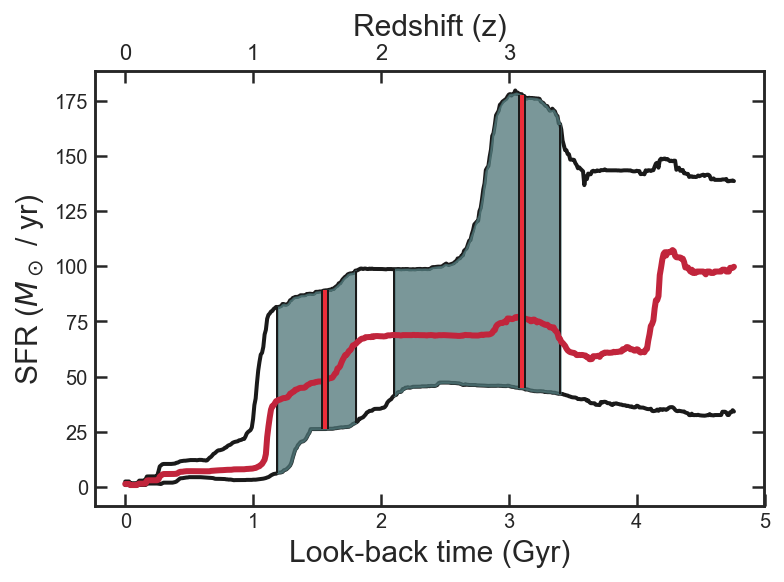

In [77]:
# field ='GND'
# galaxy=21156

# grow = mdb.query('id == {0}'.format(galaxy))

# sfh = Rescale_sfh(field, galaxy)

isfhl = interp1d(sfh.LBT,sfh.SFH_16)
isfhh = interp1d(sfh.LBT,sfh.SFH_84)

ax1 = plt.subplot()
ax2 = ax1.twiny()

# ax1.plot(sfh.fulltimes, sfh.sfr_grid.T, color = '#532436', alpha=.075, linewidth = 0.5)
ax1.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax1.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
ax1.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(0,int(sfh.fulltimes[-1])))
# ax2.set_xticklabels(np.round(lbt_to_z(np.arange(0,int(sfh.fulltimes[-1])) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
ax2.xaxis.set_ticks_position('top')

ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
ax1.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=15)
ax2.set_xlabel('Redshift (z)', fontsize=15) 
ax1.tick_params(axis='both', which='major', labelsize=10)

ax1.vlines(sfh.t_50,isfhl(sfh.t_50), isfhh(sfh.t_50), color = '#ED2D39', linewidth = 2, zorder = 11)
ax1.vlines(sfh.t_50,isfhl(sfh.t_50), isfhh(sfh.t_50), color = 'k', linewidth = 4, zorder = 10)

hdr = np.linspace(sfh.t_50_hci[0], sfh.t_50_hci[1])

ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
ax1.vlines(sfh.t_50_hci[0],isfhl(sfh.t_50_hci[0]),isfhh(sfh.t_50_hci[0]), 
               color = 'k', linewidth = 1, zorder = 8)
ax1.vlines(sfh.t_50_hci[1],isfhl(sfh.t_50_hci[1]),isfhh(sfh.t_50_hci[1]), 
               color = 'k', linewidth = 1, zorder = 8)


# ax1.vlines(sfh.t_80,isfhl(sfh.t_80), isfhh(sfh.t_80), color = '#ED2D39', linewidth = 2, zorder = 11)
# ax1.vlines(sfh.t_80,isfhl(sfh.t_80), isfhh(sfh.t_80), color = 'k', linewidth = 4, zorder = 10)

# hdr = np.linspace(sfh.t_80_hci[0], sfh.t_80_hci[1])

# ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
# ax1.vlines(sfh.t_80_hci[0],isfhl(sfh.t_80_hci[0]),isfhh(sfh.t_80_hci[0]), 
#                color = 'k', linewidth = 1, zorder = 8)
# ax1.vlines(sfh.t_80_hci[1],isfhl(sfh.t_80_hci[1]),isfhh(sfh.t_80_hci[1]), 
#                color = 'k', linewidth = 1, zorder = 8)



ax1.vlines(sfh.t_90,isfhl(sfh.t_90), isfhh(sfh.t_90), color = '#ED2D39', linewidth = 2, zorder = 11)
ax1.vlines(sfh.t_90,isfhl(sfh.t_90), isfhh(sfh.t_90), color = 'k', linewidth = 4, zorder = 10)

hdr = np.linspace(sfh.t_90_hci[0], sfh.t_90_hci[1])

ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
ax1.vlines(sfh.t_90_hci[0],isfhl(sfh.t_90_hci[0]),isfhh(sfh.t_90_hci[0]), 
               color = 'k', linewidth = 1, zorder = 8)
ax1.vlines(sfh.t_90_hci[1],isfhl(sfh.t_90_hci[1]),isfhh(sfh.t_90_hci[1]), 
               color = 'k', linewidth = 1, zorder = 8)

# ax1.vlines(sfh.t_q,isfhl(sfh.t_q),isfhh(sfh.t_q), color = '#4E7577', linewidth = 2, zorder = 11)
# ax1.vlines(sfh.t_q,isfhl(sfh.t_q),isfhh(sfh.t_q), color = 'k', linewidth = 4, zorder = 10)


# hdr = np.linspace(sfh.t_q_hci[0],sfh.t_q_hci[1])

# ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = 'k', alpha=0.6, zorder = 8)
# ax1.vlines(sfh.t_q_hci[0],isfhl(sfh.t_q_hci[0]),isfhh(sfh.t_q_hci[0]), 
#            color = 'k', linewidth = 1, zorder = 8)
# ax1.vlines(sfh.t_q_hci[1],isfhl(sfh.t_q_hci[1]),isfhh(sfh.t_q_hci[1]), 
#            color = 'k', linewidth = 1, zorder = 8)

In [91]:
select = pd.read_pickle('../spec_files/all_section.pkl')

select = select.query('AGN != "AGN" and use == True')


fitvals = {}
params = ['m', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'lm', 'z', 'd', 'lwa']
k = ['Z', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'lmass', 'zgrism', 'Av', 'lwa']

for p in range(len(params)):
    m = np.repeat(-99.0,len(select))
    hci = []
    offmass = []
    
    for i in range(len(select.index)):
        try:
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(select.field[select.index[i]], select.id[select.index[i]], params[p]))
            m[i], mreg, oreg = Highest_density_region(px,x)
            hci.append(mreg)
            offmass.append(oreg)
        except:
            hci.append([0])
            offmass.append([0])
    
    fitvals['{0}'.format(k[p])] = m
    fitvals['{0}_hci'.format(k[p])] = hci
    fitvals['{0}_modality'.format(k[p])] = offmass
    

In [94]:
tabfits = pd.DataFrame(fitvals)
tabfits['field'] = select.field.values
tabfits['id'] = select.id.values

In [100]:
#add SFH values
z_50= np.repeat(-99.0,len(tabfits))
z_50_hci = []
z_50_oreg = []
z_80= np.repeat(-99.0,len(tabfits))
z_80_hci = []
z_80_oreg = []
z_90= np.repeat(-99.0,len(tabfits))
z_90_hci = []
z_90_oreg = []
z_q= np.repeat(-99.0,len(tabfits)) 
z_q_hci = []
z_q_oreg = []
t_50= np.repeat(-99.0,len(tabfits))
t_50_hci = []
t_50_oreg = []
t_80= np.repeat(-99.0,len(tabfits))
t_80_hci = []
t_80_oreg = []
t_90= np.repeat(-99.0,len(tabfits))
t_90_hci = []
t_90_oreg = []
t_q= np.repeat(-99.0,len(tabfits))
t_q_hci = []
t_q_oreg = []
log_ssfr= np.repeat(-99.0,len(tabfits))
log_ssfr_hci = []
log_ssfr_oreg = []
for i in range(len(tabfits.index)):
#     try:
    sfh = Rescale_sfh(tabfits.field[tabfits.index[i]], tabfits.id[tabfits.index[i]])

    z_50[i] = sfh.z_50
    z_50_hci.append(sfh.z_50_hci)
    z_50_oreg.append(sfh.z_50_offreg)

    z_80[i] = sfh.z_80
    z_80_hci.append(sfh.z_80_hci)
    z_80_oreg.append(sfh.z_80_offreg)

    z_90[i] = sfh.z_90
    z_90_hci.append(sfh.z_90_hci)
    z_90_oreg.append(sfh.z_90_offreg)

    z_q[i] = sfh.z_q
    z_q_hci.append(sfh.z_q_hci)
    z_q_oreg.append(sfh.z_q_offreg)

    t_50[i] = sfh.t_50
    t_50_hci.append(sfh.t_50_hci)
    t_50_oreg.append(sfh.t_50_offreg)

    t_80[i] = sfh.t_80
    t_80_hci.append(sfh.t_80_hci)
    t_80_oreg.append(sfh.t_80_offreg)

    t_90[i] = sfh.t_90
    t_90_hci.append(sfh.t_90_hci)
    t_90_oreg.append(sfh.t_90_offreg)

    t_q[i] = sfh.t_q
    t_q_hci.append(sfh.t_q_hci)
    t_q_oreg.append(sfh.t_q_offreg)

    log_ssfr[i] = sfh.lssfr
    log_ssfr_hci.append(sfh.lssfr_hci)
    log_ssfr_oreg.append(sfh.lssfr_offreg)
        
#     except:
#         z_50_hci.append(np.array([0]))
#         z_80_hci.append(np.array([0]))
#         z_90_hci.append(np.array([0]))
#         z_q_hci.append(np.array([0]))
#         t_50_hci.append([0])
#         t_80_hci.append([0])
#         t_90_hci.append([0])
#         t_q_hci.append([0])
#         log_ssfr_hci.append([0])
        
#         z_50_oreg.append(np.array([0]))
#         z_80_oreg.append(np.array([0]))
#         z_90_oreg.append(np.array([0]))
#         z_q_oreg.append(np.array([0]))
#         t_50_oreg.append([0])
#         t_80_oreg.append([0])
#         t_90_oreg.append([0])
#         t_q_oreg.append([0])
#         log_ssfr_oreg.append([0])
        
        
# tabfits['z_50'] = z_50
# tabfits['z_50_hci'] = z_50_hci
# tabfits['z_50_modality'] = z_50_oreg

# tabfits['z_80'] = z_80
# tabfits['z_80_hci'] = z_80_hci
# tabfits['z_80_modality'] = z_80_oreg

# tabfits['z_90'] = z_90
# tabfits['z_90_hci'] = z_90_hci
# tabfits['z_90_modality'] = z_90_oreg


# tabfits['z_q'] = z_q
# tabfits['z_q_hci'] = z_q_hci
# tabfits['z_q_modality'] = z_q_oreg


# tabfits['t_50'] = t_50
# tabfits['t_50_hci'] = t_50_hci
# tabfits['t_50_modality'] = t_50_oreg

# tabfits['t_80'] = t_80
# tabfits['t_80_hci'] = t_80_hci
# tabfits['t_80_modality'] = t_80_oreg

# tabfits['t_50'] = t_50
# tabfits['t_50_hci'] = t_50_hci
# tabfits['t_50_modality'] = t_50_oreg

# tabfits['t_90'] = t_90
# tabfits['t_90_hci'] = t_90_hci
# tabfits['t_90_modality'] = t_90_oreg

# tabfits['t_q'] = t_q
# tabfits['t_q_hci'] = t_q_hci
# tabfits['t_q_modality'] = t_q_oreg


# tabfits['log_ssfr'] = log_ssfr
# tabfits['log_ssfr_hci'] = log_ssfr_hci
# tabfits['log_ssfr_modality'] = log_ssfr_oreg


KeyboardInterrupt: 